# Gardens Marketplace

Porting the [cadCAD bonding curve model](https://github.com/cadCAD-org/demos/blob/master/demos/Multiscale/bonding_curve/Bonding_Curve.ipynb) from the [Economic Games as Estimators](https://epub.wu.ac.at/7433/) paper into a Gardens cadCAD model.

## Check cadCAD

This cell doesn't do anything, but it does ensure that you know what version of cadCAD you're running. That way if/when you encounter technical difficulties you can tell the community which version of cadCAD you're running. Might save you hours of pain if all you need to do is upgrade to the latest version. 

In [23]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /usr/local/lib/python3.8/site-packages
Requires: pandas, fn, pathos, funcy
Required-by: cadCAD-diagram
Note: you may need to restart the kernel to use updated packages.


## Import Stuff

These are the libraries you'll need (cadCAD stuff) and that could be useful (python stuff) for your cadCAD model.

We're using [cadCAD Diagram](https://github.com/cadCAD-org/cadCAD_diagram), which is separate from cadCAD. If you're using the VS Code container from this repo it's already installed, but otherwise you might need to instal it.

In [24]:
# Python
import numpy as np
import random as random

# cadCAD
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
from cadCAD_diagram import diagram_from_config

# Notebook setup
experiment = Experiment()
del configs[:]

# Stuff
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

## Utility Functions

In [25]:
default_kappa= 2
default_exit_tax = .02

#value function for a given state (R,S)
def invariant(R,S,kappa=default_kappa):
    return (S**kappa)/R

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def reserve(S, V0, kappa=default_kappa):
    return (S**kappa)/V0

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def supply(R, V0, kappa=default_kappa):
    return (V0*R)**(1/kappa)

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return a spot price P as a function of reserve R
def spot_price(R, V0, kappa=default_kappa):
    return kappa*R**((kappa-1)/kappa)/V0**(1/kappa)

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#deposit deltaR to Mint deltaS
#with realized price deltaR/deltaS
def mint(deltaR, R,S, V0, kappa=default_kappa):
    deltaS = (V0*(R+deltaR))**(1/kappa)-S
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    return deltaS, realized_price

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#burn deltaS to Withdraw deltaR
#with realized price deltaR/deltaS
def withdraw(deltaS, R,S, V0, kappa=default_kappa):
    deltaR = R-((S-deltaS)**kappa)/V0
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    return deltaR, realized_price

def withdraw_with_tax(deltaS, R,S, V0, exit_tax = default_exit_tax, kappa=default_kappa):
    deltaR = R-((S-deltaS)**kappa)/V0
    #print(deltaR)
    quantity_taxed = exit_tax*deltaR
    quantity_recieved = (1-exit_tax)*deltaR

    realized_price = quantity_recieved/deltaS

    return quantity_recieved, quantity_taxed, realized_price

def response_plot(rdf, title):
    plt.subplots(figsize=(10,6))
    ax1=plt.subplot(2,1,1)
    rdf[["spot_price","price"]].plot(ax=ax1)
    plt.legend(["spot price (output: $P_t$)", "price sample (input: $\hat P_t$)" ])
    plt.ylabel("Price, $\hat P_t$, $P_t$")
    plt.title(title+" Response Dynamics")
    ax2=plt.subplot(2,1,2)
    rdf[["abs_err"]].plot(ax=ax2,logy=True, color='green')
    plt.legend(["$Error: |P_t-\hat P_t|$" ])
    plt.xlabel("transaction count (time)")
    plt.ylabel("Absolute Value of Estimation Error")
    plt.show()


## Initial Params

These are the parameters that control the behavior of a system. For example, if you were modeling a Web3 protocol these would be the parameters within a system that token holders could vote to modify. All of the parameters of a protocol that can be modified should be accessible here. That way it's easy to modify and run similations to explore how parameter changes might affect the network.

In [26]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta) # initial reserve
S0 = hatch_raise/hatch_price # initial supply

kappa = 2 # bonding curvature parameter
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

initial_conditions = {
    'R0':R0,
    'S0':S0,
    'V0':V0,
    'P0':P0
}

sys_params = {
    'kappa': [kappa],
    'invariant': [V0],
    'dust' : [10**-8],
    'rule' : ['martin' for r in range(10)],
    'dP' : ['N/A' for r in range(10)],
    'sigma': [.1*(.5**(r+1)) for r in range(10)],
    'period': ['N/A' for r in range(10)],
    'phi': [0], #phi for exiting funds
    'beta': [0.9], #beta is param for armijo rule
}


In [27]:
# Genesis States
genesis_states = {
    'supply': initial_conditions['S0'],
    'price': initial_conditions['P0'],
    'reserve': initial_conditions['R0'],
    'spot_price': initial_conditions['P0'],
    'output_price': initial_conditions['P0'],
}

# The parameters to run the model
params = {
    'M': sys_params, # system parameters
    'T': range(4000), # number of timesteps
    'N': 10 # number of monte carlo runs
}

## Policy Functions

Policy functions are like flows in stock and flow diagrams. They modify the inputs to state update functions.

In [28]:
# Behaviors
def set_action(params, step, sL, s):

    R = s['reserve']
    S = s['supply']
    V0 = params['invariant']
    P=s['spot_price']
    period = params['period']

    if params['rule'] == 'step':
        bump = int((s['timestep'] % int(period/2) == 0))*int(s['timestep']>0)
        sign = -(-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*bump*sign
    elif params['rule'] == 'ramp':
        sign = (-1)**int((2*s['timestep']/period))
        new_price = s['price'] + params['dP']*sign
    elif params['rule'] == 'sin':
        new_price = P + params['dP']*np.sin(2*np.pi*s['timestep']/period)
    elif params['rule']=='martin' :
        rv = np.random.normal(0, params['sigma'])
        new_price = s['price']+s['price']*rv
    else :
        new_price = s['price']

    if P>new_price:
        mech = 'burn'

        #approx for burn s.t. p=phat
        #armijo style
        amt = S*(1-params['dust'])

        def pbar(amt):
            output = withdraw(amt, R,S, V0, params['kappa'])

            if not(output[1])>0:
                return np.Infinity
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)< new_price:
                amt = amt*params['beta']

    else:
        mech = 'bond'
        #approx for buy s.t. p=phat
        #armijo style
        amt = R*(1-params['dust'])

        def pbar(amt):
            output = mint(amt, R,S, V0, params['kappa'])

            if not(output[1])>0:
                return 0
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)> new_price:
                amt = amt*params['beta']

    action = {'mech':mech, 'amt':amt,'pin':new_price ,'pbar':pbar(amt),'posterior':{}}

    if action['mech'] == 'bond':
        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        P = spot_price(R, V0, params['kappa'])

    elif action['mech'] == 'burn':
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        S = S-amt
        P = spot_price(R, V0, params['kappa'])

    action['posterior'] = {'S':S, 'R':R,'P':P}

    return {'action': action}



## State Update Functions

These functions take in inputs (state variables and policies) and modify the state.

In [29]:
# Mechanisms
def update_S(params, step, sL, s, _input):

    action = _input['action']
    S = action['posterior']['S']

    key = 'supply'
    value = S

    return (key, value)

def update_R(params, step, sL, s, _input):

    action = _input['action']
    R = action['posterior']['R']

    key = 'reserve'
    value = R

    return (key, value)

def update_P(params, step, sL, s, _input):

    action = _input['action']
    P = action['posterior']['P']

    key = 'spot_price'
    value = P

    return (key, value)

def update_Pbar(params, step, sL, s, _input):

    action = _input['action']
    pbar = action['pbar']

    key = 'output_price'
    value = pbar

    return (key, value)

def capture_Pin(params, step, sL, s, _input):

    Pin = _input['action']['pin']
    if Pin== 0:
        print(_input['action'])
    key = 'price'
    value = Pin

    return (key, value)


## State Update Block

If you're approaching cadCAD from Web3 you can think of the state of the model as something that evolves in blocks. Each block has a set of actions that updates the state. Those transactions then get batched into blocks to be processed together. In cadCAD blocks are called "`partial_state_update_blocks`." As you can see below, this is an array that is very similar to a "block" in a blockchain in that it represents a set of actions to update the state. That state is then updated across many timesteps. This is similar to how the state of a blockchain is updated over many timesteps as new blocks are added.



In [30]:
partial_state_update_blocks = [
    {
      # system.py
      'policies': {
          'act': set_action,
        },
        'variables': {
            'supply': update_S,
            'reserve': update_R,
            'spot_price': update_P,
            'output_price': update_Pbar,
            'price': capture_Pin,
        }
    }
]

## Running the cadCAD Engine

In [31]:
experiment.append_configs(
    initial_state = genesis_states,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = config_sim(params)
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs) 
raw_system_events, tensor_field, sessions = simulation.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 10
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (4000, 9, 10, 5)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

## Data Visualization

This is often half the battle. Not only do need to design and build a cadCAD model, but you need to understand how it's working and be able to effectively communicate that to other people. A picture says a thousand words, thus enter data viz. Getting good at using python data viz libraries is probably the highest leverage thing you can do after you learn the cadCAD basics.

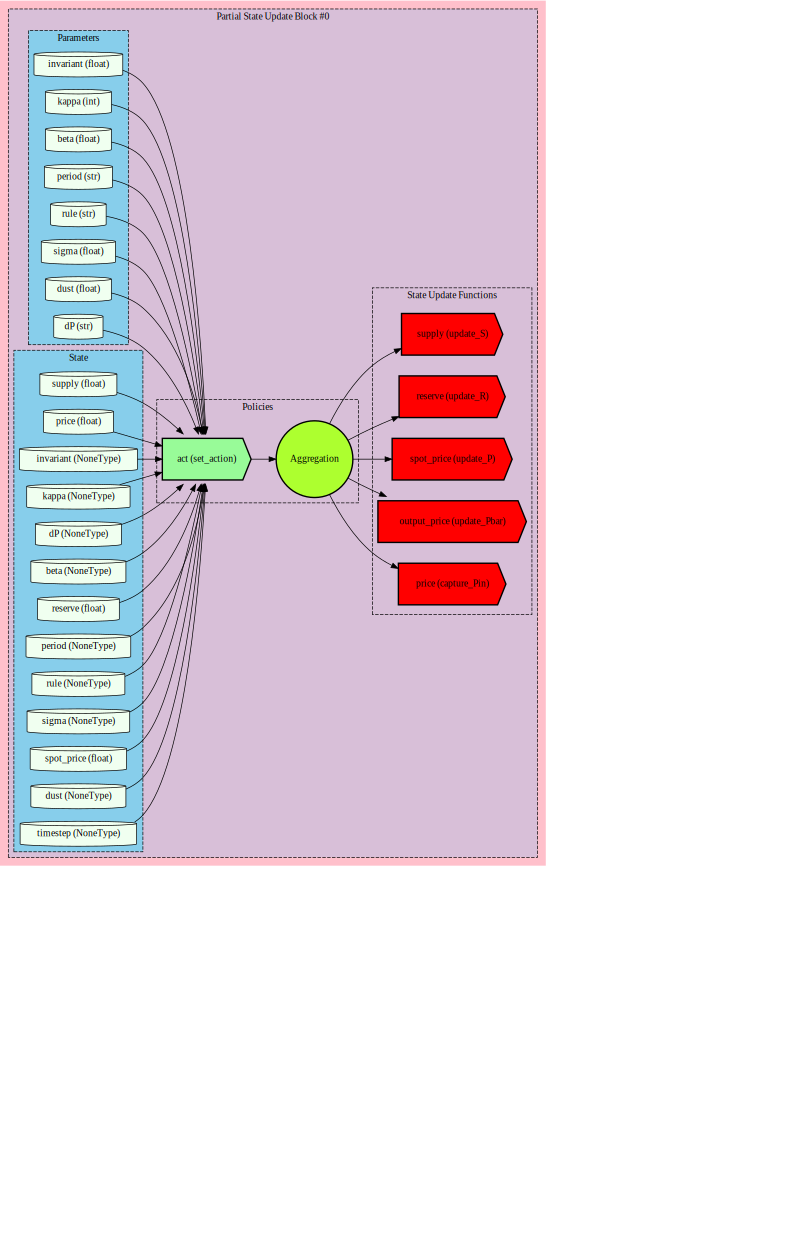

In [32]:
diagram_from_config(configs[0])

In [33]:
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

supply     price       reserve  spot_price  \
subset run timestep substep                                                     
0      1   0        0        1.000000e+06  0.100000  50000.000000    0.100000   
           1        1        1.237514e+06  0.112352  76572.049734    0.123751   
           2        1        8.491690e+05  0.104194  36054.401572    0.084917   
           3        1        1.142440e+06  0.100228  65258.466553    0.114244   
           4        1        8.197813e+05  0.096390  33602.065655    0.081978   
...                                   ...       ...           ...         ...   
9      10  3996     1        9.914305e+05  0.099147  49146.724764    0.099143   
           3997     1        9.916821e+05  0.099156  49171.668141    0.099168   
           3998     1        9.912744e+05  0.099147  49131.247672    0.099127   
           3999     1        9.918002e+05  0.099154  49183.381654    0.099180   
           4000     1        9.912968e+05  0.099153  49133.470360    0.099130   

                             output_price  simulation  
subset run timestep substep                            
0      1   0        0            0.100000           0  
           1        1            0.111876           0  
           2        1            0.104334           0  
           3        1            0.099580           0  
           4        1            0.098111           0  
...                                   ...         ...  
9      10  3996     1            0.099147           9  
           3997     1            0.099156           9  
           3998     1            0.099148           9  
           3999     1            0.099154           9  
           4000     1            0.099155           9  

[400100 rows x 6 columns]

In [35]:
simulation_result.plot('timestep', ['supply', 'price', 'reserve'], grid=True, 
        colormap = 'gist_rainbow',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['supply']+simulation_result['price']+simulation_result['reserve']).max())))

TypeError: 'numpy.float64' object cannot be interpreted as an integer